# Homework 7 - ONNX Model Deployment

## Setup
First, let's download the model files and install required libraries.

In [1]:
# Install required libraries
!pip install onnxruntime pillow numpy

In [2]:
import urllib.request
import os

PREFIX = "https://github.com/alexeygrigorev/large-datasets/releases/download/hairstyle"
DATA_URL = f"{PREFIX}/hair_classifier_v1.onnx.data"
MODEL_URL = f"{PREFIX}/hair_classifier_v1.onnx"

if not os.path.exists('hair_classifier_v1.onnx.data'):
    print("Downloading model data file...")
    urllib.request.urlretrieve(DATA_URL, 'hair_classifier_v1.onnx.data')
    print("Done!")

if not os.path.exists('hair_classifier_v1.onnx'):
    print("Downloading model file...")
    urllib.request.urlretrieve(MODEL_URL, 'hair_classifier_v1.onnx')
    print("Done!")

## Question 1: Input/Output Node Names

Let's load the ONNX model and find the input and output node names.

In [3]:
import onnxruntime as ort

session = ort.InferenceSession('hair_classifier_v1.onnx')

# Get input details
print("Input nodes:")
for inp in session.get_inputs():
    print(f"  Name: {inp.name}")
    print(f"  Shape: {inp.shape}")
    print(f"  Type: {inp.type}")
    print()

# Get output details
print("Output nodes:")
for out in session.get_outputs():
    print(f"  Name: {out.name}")
    print(f"  Shape: {out.shape}")
    print(f"  Type: {out.type}")

Input nodes:
  Name: input
  Shape: ['s77', 3, 200, 200]
  Type: tensor(float)

Output nodes:
  Name: output
  Shape: ['s77', 1]
  Type: tensor(float)


## Question 2: Target Size

Based on the input shape from the model, we can determine the target size.

In [4]:

input_shape = session.get_inputs()[0].shape
print(f"Input shape: {input_shape}")

if input_shape[1] == 3:  # channels first format
    target_size = (input_shape[2], input_shape[3])
else:  # channels last format
    target_size = (input_shape[1], input_shape[2])

print(f"Target size: {target_size}")

Input shape: ['s77', 3, 200, 200]
Target size: (200, 200)


## Image Preparation Functions

In [5]:
from io import BytesIO
from urllib import request
from PIL import Image
import numpy as np

def download_image(url):
    with request.urlopen(url) as resp:
        buffer = resp.read()
    stream = BytesIO(buffer)
    img = Image.open(stream)
    return img

def prepare_image(img, target_size):
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize(target_size, Image.NEAREST)
    return img

## Question 3: Pre-processing

Download and preprocess the image, then check the value in the first pixel R channel.

In [6]:
url = "https://habrastorage.org/webt/yf/_d/ok/yf_dokzqy3vcritme8ggnzqlvwa.jpeg"
img = download_image(url)
print(f"Original image size: {img.size}")
img_prepared = prepare_image(img, target_size)
print(f"Prepared image size: {img_prepared.size}")

Original image size: (1024, 1024)
Prepared image size: (200, 200)


In [7]:

x = np.array(img_prepared, dtype=np.float32)
print(f"Array shape: {x.shape}")
print(f"First pixel RGB values (raw): {x[0, 0]}")

x = x / 255.0
print(f"First pixel RGB values (after /255): {x[0, 0]}")

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

x = (x - mean) / std
print(f"First pixel RGB values (after normalization): {x[0, 0]}")
print(f"\nValue in first pixel, R channel: {x[0, 0, 0]:.3f}")

Array shape: (200, 200, 3)
First pixel RGB values (raw): [ 61. 104.  22.]
First pixel RGB values (after /255): [0.23921569 0.40784314 0.08627451]
First pixel RGB values (after normalization): [-1.07329394 -0.21498597 -1.42100217]

Value in first pixel, R channel: -1.073


**Answer Q3:** The value in the first pixel R channel is shown above.

## Question 4: Model Output

Apply the model to the preprocessed image.

In [8]:

x_input = np.transpose(x, (2, 0, 1)) 
x_input = np.expand_dims(x_input, axis=0)  
x_input = np.array(x_input, dtype=np.float32)
print(f"Input shape for model: {x_input.shape}")

# Get input name
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

print(f"Input name: {input_name}")
print(f"Output name: {output_name}")

# Run inference
result = session.run([output_name], {input_name: x_input})
output = result[0]
print(f"\nModel output: {output}")
print(f"Output value: {output[0][0]:.2f}")

Input shape for model: (1, 3, 200, 200)
Input name: input
Output name: output

Model output: [[0.09156627]]
Output value: 0.09


## Prepare Lambda Code

Let's create a separate Python file for the Lambda function.

In [9]:
lambda_code = '''
import onnxruntime as ort
import numpy as np
from io import BytesIO
from urllib import request
from PIL import Image

# Model configuration
MODEL_PATH = "hair_classifier_empty.onnx"
TARGET_SIZE = (200, 200)

# ImageNet normalization parameters
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])

# Load model once (outside handler for Lambda optimization)
session = ort.InferenceSession(MODEL_PATH)
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name


def download_image(url):
    with request.urlopen(url) as resp:
        buffer = resp.read()
    stream = BytesIO(buffer)
    img = Image.open(stream)
    return img


def prepare_image(img, target_size):
    if img.mode != "RGB":
        img = img.convert("RGB")
    img = img.resize(target_size, Image.NEAREST)
    return img


def preprocess(img):
    x = np.array(img, dtype=np.float32)
    x = x / 255.0
    x = (x - MEAN) / STD
    x = np.transpose(x, (2, 0, 1))  # (H, W, C) -> (C, H, W)
    x = np.expand_dims(x, axis=0)  # Add batch dimension
    return x


def predict(url):
    img = download_image(url)
    img = prepare_image(img, TARGET_SIZE)
    x = preprocess(img)
    result = session.run([output_name], {input_name: x})
    return float(result[0][0][0])


def lambda_handler(event, context):
    url = event.get("url")
    if not url:
        return {"statusCode": 400, "body": "Missing url parameter"}
    
    prediction = predict(url)
    return {"statusCode": 200, "prediction": prediction}


if __name__ == "__main__":
    # Test locally
    url = "https://habrastorage.org/webt/yf/_d/ok/yf_dokzqy3vcritme8ggnzqlvwa.jpeg"
    result = predict(url)
    print(f"Prediction: {result}")
'''

with open('lambda_function.py', 'w') as f:
    f.write(lambda_code.strip())

print("Lambda function code saved to lambda_function.py")

Lambda function code saved to lambda_function.py


## Question 5: Docker Base Image Size

Pull the base image and check its size.

**Ran this in wsl in local sys - **
docker pull agrigorev/model-2025-hairstyle:v1
**Output**: 608MB
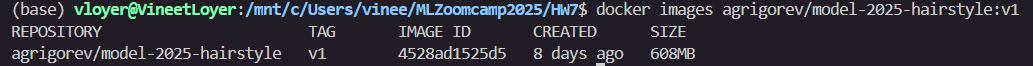

## Question 6: Extended Docker Image

Create a Dockerfile that extends the base image with our Lambda code.

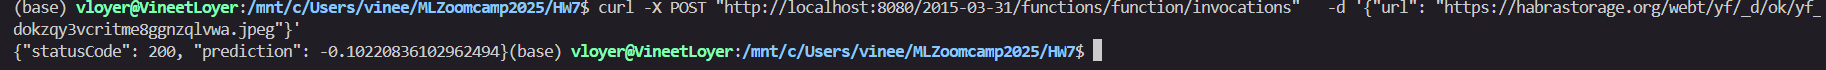